# EM Shower and calorimeters
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### (2) Definition of shower class

In [3]:
# Class for single shower particle

class shParticle:
    'Particle of the EM shower (in 1D)'
    E = 0.0
    q = 0
    xmin = 0.0
    xmax = 0.0
    
    def __init__(self,E,q,xmin):
        self.E = E
        self.q = q
        self.xmin = xmin
        self.xmax = xmin
        
    def __str__(self):
        if self.xmin == self.xmax :
            return 'E = %g   q = % g    created at X = %g [X0]' % (self.E, self.q, self.xmin)
        else :
            return 'E = %g   q = % g    propagated from X = %g to %g  [X0]' % (self.E, self.q, self.xmin, self.xmax)
        
    def setlen(self,shlen):
        self.xmax = self.xmin + shlen
 
    def getlen(self):
        return self.xmax - self.xmin
    
    def getsamp(self,dX):
        i1 = int(self.xmin/dX)
        i2 = int(self.xmax/dX)
        return i2-i1


In [4]:
# Test the particle class

x = shParticle(10.,-1.,0.)
print(x)
x.setlen(1.2)
print(x)

E = 10   q = -1    created at X = 0 [X0]
E = 10   q = -1    propagated from X = 0 to 1.2  [X0]


In [5]:
# EM shower class

class emShower:
    'Model of EM shower development'

    def __init__(self,E0,q0,x0):
        # initialize with input particle
        self.shower = []
        self.shower.append(shParticle(E0,q0,x0))
        # only propagated particles are counted
        # so set counters to zero at that point
        self.npar = 0  
        self.nch = 0
        self.chlen = 0.0
        self.eloss = 0.0

    def __str__(self):
        return 'Shower with %d particles, %d charged, total track lenght %g X0, energy loss %g GeV' % (self.npar, self.nch, self.chlen, self.eloss)
    
    def develope(self,Ec,dEdx=0.0):
        # consider increasing number of particles in the shower
        for par in self.shower :
            # conversion/radiation length [X0]
            if par.q == 0 :
                intlen = 9.0/7.0
            else :
                intlen = 1.0
               
            # generate conversion/radiation point
            
            shlen = np.random.exponential(intlen)
            
            # check energy loss of particle
            
            elen = 0
            
            if par.q != 0 and dEdx > 0 :
                elen = shlen * dEdx
                if elen > par.E :
                    shlen = par.E/dEdx
                    elen = par.E
            
            # propagate particle to this point
            
            par.setlen(shlen)
            self.npar+=1
            if par.q != 0 :
                self.nch+=1
                self.chlen+=shlen
                self.eloss+=elen

            # Energy at the final point
            
            Eleft = par.E - elen
            
            # Final point - origin for new particles
            
            xnew = par.xmax 
           
            # If above critical energy:
            #   convert gamma to two photons or radiate photon
            if Eleft > Ec :
                E1 = Eleft * np.random.random(1)    #  Very siplified energy splitting
                E2 = Eleft - E1
                if par.q == 0 :
                    self.shower.append(shParticle(E1,+1,xnew))
                    self.shower.append(shParticle(E2,-1,xnew))
                else:
                    self.shower.append(shParticle(E1,par.q,xnew))
                    self.shower.append(shParticle(E2,0,xnew))
                    
    def sample(self,Xsamp):
        nsamp = 0
        for par in self.shower:
            if par.q != 0 :
                nsamp += par.getsamp(Xsamp)
        return nsamp

    def profile(self,Nbin,Xmax):
        hprof = TH1D("hprof","Shower profile",Nbin, 0, Xmax)
        hprof.GetXaxis().SetTitle("x [X0]")
        hprof.GetYaxis().SetTitle("Particles")
        dX=Xmax/Nbin
        for par in self.shower:
            if par.q != 0 :
                nx = par.getsamp(dX)
                for ix in range(nx):
                    hprof.Fill(par.xmin+ix*dX)
        return hprof
    
    def dump(self,Nprt):
        for iprt in range(Nprt):
            print(self.shower[iprt])
            

### (3) Shower simulation

In [6]:
#  Incident particle

E0 = 5.
q0 = -1

# Initialise shower with incident particle

myshower = emShower(E0,q0,0.)

print(myshower.shower[0])

E = 5   q = -1    created at X = 0 [X0]


In [7]:
# Critical energy [GeV] for Copper

Ec = 0.020

# Ionization losses [GeV/X0] for Copper (MIP)

dEdx = 0.018

# Execute shower development procedure

myshower.develope(Ec,dEdx)

# Test shower dump (first 10 rows)

myshower.dump(10)

E = 5   q = -1    propagated from X = 0 to 3.98159  [X0]
E = 3.09908   q = -1    propagated from X = 3.98159 to 4.58108  [X0]
E = 1.82925   q =  0    propagated from X = 3.98159 to 5.80307  [X0]
E = 0.609612   q = -1    propagated from X = 4.58108 to 6.60913  [X0]
E = 2.47868   q =  0    propagated from X = 4.58108 to 4.73881  [X0]
E = 1.34856   q =  1    propagated from X = 5.80307 to 5.95296  [X0]
E = 0.48069   q = -1    propagated from X = 5.80307 to 7.0254  [X0]
E = 0.238379   q = -1    propagated from X = 6.60913 to 6.82144  [X0]
E = 0.334729   q =  0    propagated from X = 6.60913 to 6.99134  [X0]
E = 2.10025   q =  1    propagated from X = 4.73881 to 4.88672  [X0]


In [8]:
# Shower summary

print(myshower)

Shower with 435 particles, 304 charged, total track lenght 215.603 X0, energy loss 3.88085 GeV


In [9]:
# Direct access to shower information
# Can be used to model response of the uniform calorimeter

print('Shower with ',myshower.npar,' particles, ',myshower.nch,' charged particles')
print('Total length of charged particle tracks: ',myshower.chlen)

Shower with  435  particles,  304  charged particles
Total length of charged particle tracks:  [215.60268153]


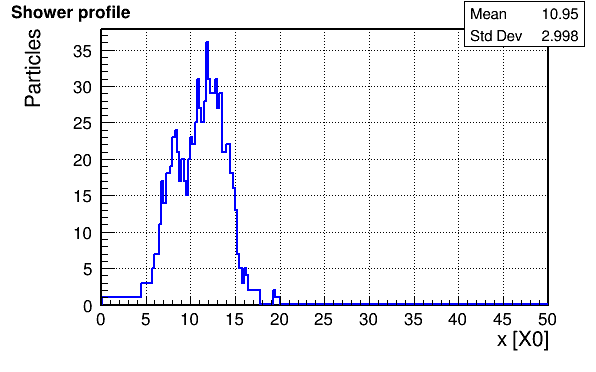

Info in <TCanvas::Print>: png file shprofile.png has been created


In [10]:
# Histogram of the longitudinal shower profile

Xmax = 50.
Nprof = 200

shprofile=myshower.profile(Nprof,Xmax)

csh = TCanvas('csh')

shprofile.DrawCopy()

csh.Update()
csh.Print('shprofile.png')

Image(filename='shprofile.png')

### (4) Average profile

In [11]:
# Repeat shower simulation multiple times

avprofile=shprofile
avprofile.SetNameTitle("havprof","Average shower profile")
avprofile.Reset()

Nmc = 1000
myshowers = []

for imc in range(Nmc):
    newshower = emShower(E0,q0,0.)
    newshower.develope(Ec,dEdx)
    myshowers.append(newshower)
    if (imc+1)%100 == 0:
        print(imc+1,' showers generated ',myshowers[imc].npar,' particles')

100  showers generated  407  particles
200  showers generated  465  particles
300  showers generated  437  particles
400  showers generated  423  particles
500  showers generated  421  particles
600  showers generated  423  particles
700  showers generated  397  particles
800  showers generated  391  particles
900  showers generated  413  particles
1000  showers generated  437  particles


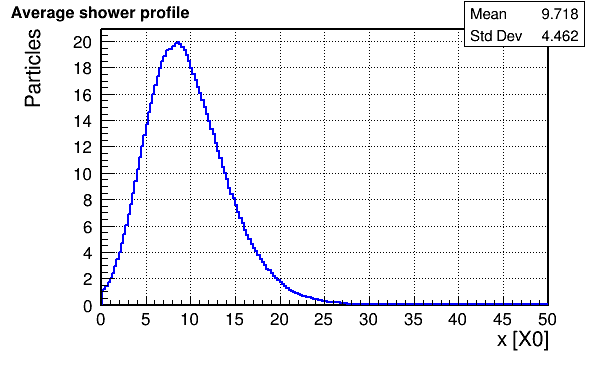

Info in <TCanvas::Print>: png file avprofile.png has been created


In [12]:
# Average generated showers

wmc = 1/Nmc

for newshower in myshowers:
    newprofile=newshower.profile(Nprof,Xmax)
#    newprofile=myshowers[imc].profile(Nprof,Xmax)
    avprofile.Add(newprofile,wmc)
    newprofile.Delete()

csh2 = TCanvas('csh2')

avprofile.DrawCopy()

csh2.Update()
csh2.Print('avprofile.png')

Image(filename='avprofile.png')

### (5) Uniform calorimeter

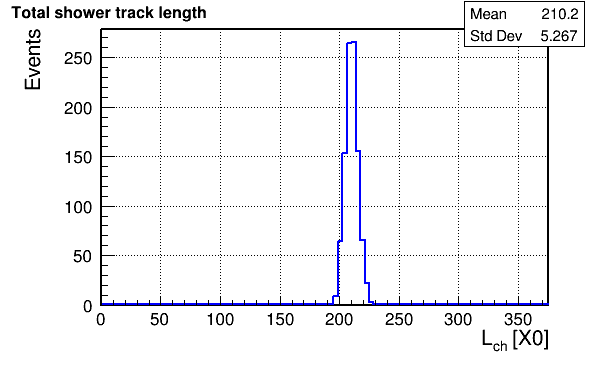

Info in <TCanvas::Print>: png file hchlen.png has been created


In [13]:
# Prepare response histograms

Nbin = 100

Lmax = 1.5*E0/Ec

hchlen = TH1D("hchlen","Total shower track length",Nbin, 0, Lmax)
hchlen.GetXaxis().SetTitle("L_{ch} [X0]")
hchlen.GetYaxis().SetTitle("Events")

# Scan simulated showers

dchlen = []
dchlen.clear()

for shower in myshowers:
    dchlen.append(shower.chlen)
    hchlen.Fill(shower.chlen)


clen = TCanvas('clen')

hchlen.DrawCopy()

clen.Update()
clen.Print('hchlen.png')

Image(filename='hchlen.png')

In [14]:
print('Uniform calorimeter model: ',100*np.std(dchlen)/np.mean(dchlen),'% resolution')

Uniform calorimeter model:  2.505373744994728 % resolution


### (6) Sampling calorimeter

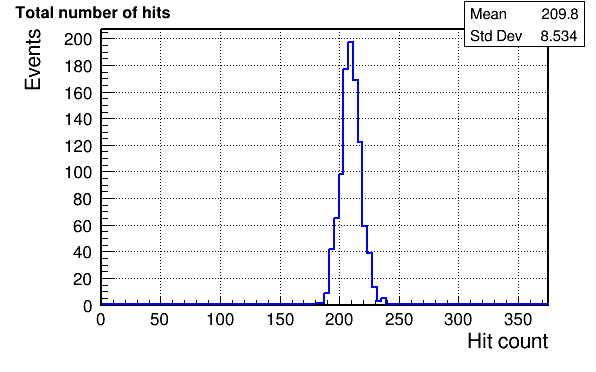

Info in <TCanvas::Print>: png file hchhit.png has been created


In [15]:
# Sampling distance [X0]

Xsamp = 1.0

# Prepare response histograms

Nbin = 94

Lmax = 1.5*E0/Ec
Nmax = Lmax/Xsamp

hchhit = TH1D("hchhit","Total number of hits",Nbin, 0, Nmax)
hchhit.GetXaxis().SetTitle("Hit count")
hchhit.GetYaxis().SetTitle("Events")

# Sample generated showers
dchhit = []
dchhit.clear()

for shower in myshowers:
    nsamp=shower.sample(Xsamp)
    dchhit.append(nsamp)
    hchhit.Fill(nsamp)

# Plot histogram

chit = TCanvas('chit')

hchhit.DrawCopy()

chit.Update()
chit.Print('hchhit.png')

Image(filename='hchhit.png')

In [16]:
print('Sampling calorimeter model: ',100*np.std(dchhit)/np.mean(dchhit),'% resolution')

Sampling calorimeter model:  4.068427856822652 % resolution
